# Project 0: 🍔👁 Food Vision Big™
Image classification of 101 food classes.

In the previous notebook (transfer learning part 3: scaling up) we built Food Vision mini: a transfer learning model which beat the original results of the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with only 10% of the data.

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

This time we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment), a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

>**🔑 Note:** Top-1 accuracy means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). Top-5 accuracy means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.



## Check GPU

Google Colab offers free GPUs,all of them are comaptible for mixed precision training.. however,if you use other GPU not all of them are compatible with mixed precision training.

Google Colab offers:
* A100(compatible)
* V100(compatible)
* Tesla T4(compatible)
Knowing this, in order to use mixed precision training we need access to any one or if we're using our own hardware, our GPU needs a score of 7.0+(see here: https://developer.nvidia.com/cuda/cuda-gpus)


In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3e2ab0b6-e2d4-9d1e-8244-e45090d356e3)


## Get helper functions


In [2]:
# Download helper functions
!wget https://raw.githubusercontent.com//mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-20 09:13:30--  https://raw.githubusercontent.com//mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py [following]
--2023-09-20 09:13:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-20 09:13:30 (115 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [166]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data

## Use TensorFlow Datasets to Download Data

In [1]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [2]:
# list all available datasets
datasets_list = tfds.list_builders() # Get all available datasets in TFDS
print("food101" in datasets_list) # is our target datset in TFDS

True


In [138]:
# Load in the data(takes 5-6 minutes in Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True, #Data get returned in tuple format(data, label)
                                             with_info= True)

## Exploting the Food101 data from  TensorFlow Datasets
To become one with our data, we want to find:
* Class names
* The shape of our input data(image tensors)
* The datatype of our input data
* What the labels look like(e.g. are they one-hot encoded or they are label encoded)
* Do the labels match up with the class names?

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo n

In [5]:
# Feature of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [7]:
# Take one sample of the train data
train_one_sample = train_data.take(1)  # samples are in format (image_tensor, label)

In [8]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [63]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype : {image.dtype}
  Target class from Food101(tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype : <dtype: 'uint8'>
  Target class from Food101(tensor form): 56
  Class name (str form): huevos_rancheros
  


In [64]:
# What does our image tensor from TFDS's Food 101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [65]:
# What are the min and max values of image tensor?
import tensorflow as tf

tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

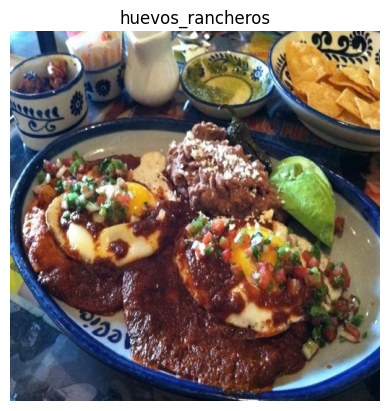

In [66]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data
Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc.)

However, not all data(including data from TensorFlow Datasets) comes like this.

So, in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to our data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 and 255)

What we know model like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1 ) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since, we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data(these architectures have rescaling built-in)

This means our fucntions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors `uint8` to `float32`

In [67]:

# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  return tf.cast(image, tf.float32), label # return (float32_image, label)


In [68]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}")
print(f"Image after preprocessed: \n{preprocessed_img[:2]}...,\nShape:{preprocessed_img.shape}, \nDatatype:{preprocessed_img.dtype} ")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>
Image after preprocessed: 
[[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]...,
Shape:(224, 224, 3), 
Datatype:<dtype: 'float32'> 


## Batch & prepare datasets

We'now going to make our data input pipeline run really fast

For more resources on this: https://www.tensorflow.org/guide/data_performance

In [120]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [121]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

>"Hey, TensorFlow, map this preprocessing function(`preprocess_img`) across the training dataset, then shuffle a number of elements and then batch them together and finally make sure to prepare new batches(prefetch) whilst the model is looking through(finding patterns) the current batch."

## Create modelling callbacks

We're going to create some of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if needed to)
* ModelCheckPoint callback to save our model's progress after feature extraction

In [ ]:
# Create tensorboard (import from helper_function)
from helper_functions import create_tensorboard_callback

# Create a ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor="val_acc",
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=0)

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, checkout training guide: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 datatypes to speed up model performance

In [ ]:
# Turn ON mixed precision training
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")#set global data policy to mixed precision

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable= False

# Create functional model
inputs= layers.Input(shape=input_shape, name ="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if model do not have it try belo:
# x= preprocessing.Rescaling(1/255.)(x)
x = base_model(inputs, training=False) #make sure layers which should be in inference mode only say like that
x= layers.GlobalAveragePooling2D(name="global_pool_layer")(x)
x= layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model= tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_pool_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
# check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_pool_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the dtype policy for base model
for  layer in base_model.layers[:20]:
    print( layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

## Fit the feature extraction model

In [ ]:
history_101_food_classes_feature_extract = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                   validation_steps=int(0.15 * len(test_data)),
                   validation_data=(test_data),
                   epochs=4,
                   callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                         experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                             model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230919-112750
Epoch 1/4
2368/2368 [==============================] - ETA: 0s - loss: 1.7200 - accuracy: 0.5813

2368/2368 [==============================] - 184s 72ms/step - loss: 1.7200 - accuracy: 0.5813 - val_loss: 1.1242 - val_accuracy: 0.7021
Epoch 2/4
2368/2368 [==============================] - ETA: 0s - loss: 1.2017 - accuracy: 0.6887

2368/2368 [==============================] - 170s 70ms/step - loss: 1.2017 - accuracy: 0.6887 - val_loss: 1.0284 - val_accuracy: 0.7195
Epoch 3/4
2368/2368 [==============================] - ETA: 0s - loss: 1.0556 - accuracy: 0.7236

2368/2368 [==============================] - 162s 68ms/step - loss: 1.0556 - accuracy: 0.7236 - val_loss: 0.9923 - val_accuracy: 0.7240
Epoch 4/4
2367/2368 [============================>.] - ETA: 0s - loss: 0.9621 - accuracy: 0.7464

2368/2368 [==============================] - 164s 69ms/step - loss: 0.9621 - accuracy: 0.7464 - val_loss: 0.9739 - val_accuracy: 0.7352


In [ ]:
# Evaluate model on whole data
results_feature_extractor = model.evaluate(test_data)

790/790 [==============================] - 49s 62ms/step - loss: 0.9846 - accuracy: 0.7301


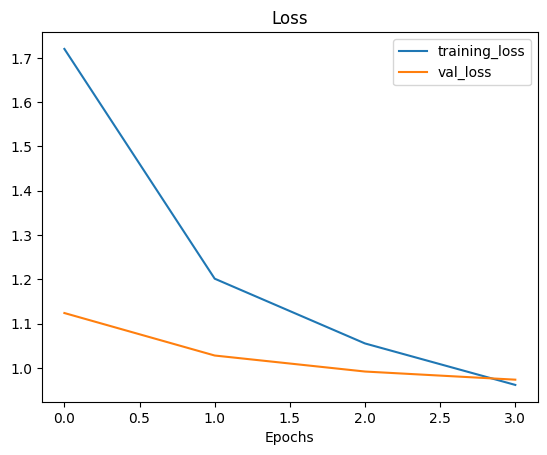

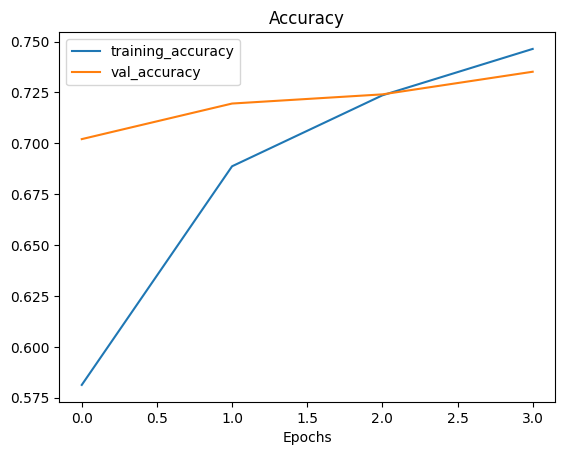

In [ ]:
# Plot loss and accuracy curve
plot_loss_curves(history_101_food_classes_feature_extract)

In [ ]:
# Save the model
model.save("foodvision_feature_extractor_model.h5")

In [ ]:
import gdown
gdown.download('https://drive.google.com/uc?id=10tyGk2NRyODcuGsz0frKe3TC6wVB9Pk2')

Downloading...
From: https://drive.google.com/uc?id=10tyGk2NRyODcuGsz0frKe3TC6wVB9Pk2
To: /content/foodvision_feature_extractor_model.h5
100%|██████████| 18.2M/18.2M [00:00<00:00, 18.3MB/s]


'foodvision_feature_extractor_model.h5'

## Fine tuning the model
Fine-tuning the feature extraction model to beat the  [DeepFoodPaper](https://arxiv.org/pdf/1606.05675.pdf)

In [ ]:
# Loading feature extractor model
feature_extractor_model = tf.keras.models.load_model("/content/foodvision_feature_extractor_model.h5")

In [ ]:
# How does the loaded model perform? (evaluate it on the test dataset)
loaded_model_results= feature_extractor_model.evaluate(test_data)

790/790 [==============================] - 53s 62ms/step - loss: 0.9894 - accuracy: 0.7280


In [ ]:
# Get the summary of downloaded model
feature_extractor_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_pool_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
for layer in feature_extractor_model.layers[1].layers:
    layer.trainable = True

In [ ]:
# Check all layers are trainable in feature extractor
for layer in feature_extractor_model.layers[1].layers:
    print(layer.name, layer.trainable)

input_1 True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_activation True
block2b_dwconv True
block2b_bn True
block2b_activation True
block2b_se_squeeze True
block2b_se_reshape True
block2b_se_reduce True
block2b_se_expand True
block2b_se_excite True
block2b_project_conv True
block2b_project_bn True
block

In [ ]:
# Check to see what dtype_policy of the layers in your loaded model are
for layer in feature_extractor_model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_pool_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

In [ ]:
# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
fine_tune_checkpoint_path = "fine_tune_checkpoint/cp.ckpt"

fine_tune_checkpoint= tf.keras.callbacks.ModelCheckpoint(fine_tune_checkpoint_path,
                                                        save_best_only=True,
                                                        monitor="val_loss",
                                                        save_weights_only=True)

In [ ]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
feature_extractor_model.compile(loss="sparse_categorical_crossentropy",
                               optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                               metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)..Use 100 epochs as the default..Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
history_fine_tune_model = feature_extractor_model.fit(train_data,
                                                     epochs=100,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                      callbacks=[fine_tune_checkpoint, early_stopping_callback,
                                                                create_tensorboard_callback(dir_name="training_logs",
                                                                                           experiment_name="fine_tune_101_food_class")])


Saving TensorBoard log files to: training_logs/fine_tune_101_food_class/20230919-121226
Epoch 1/100
2368/2368 [==============================] - 338s 135ms/step - loss: 0.8254 - accuracy: 0.7743 - val_loss: 0.8555 - val_accuracy: 0.7667
Epoch 2/100
2368/2368 [==============================] - 321s 135ms/step - loss: 0.4937 - accuracy: 0.8624 - val_loss: 0.8087 - val_accuracy: 0.7839
Epoch 3/100
2368/2368 [==============================] - 312s 131ms/step - loss: 0.2661 - accuracy: 0.9246 - val_loss: 0.9415 - val_accuracy: 0.7791
Epoch 4/100
2368/2368 [==============================] - 317s 133ms/step - loss: 0.1389 - accuracy: 0.9587 - val_loss: 1.0353 - val_accuracy: 0.7797
Epoch 5/100
2368/2368 [==============================] - 318s 134ms/step - loss: 0.0945 - accuracy: 0.9702 - val_loss: 1.0869 - val_accuracy: 0.7913


In [ ]:
feature_extractor_model.evaluate(test_data)

790/790 [==============================] - 48s 61ms/step - loss: 1.1478 - accuracy: 0.7780


[1.1478476524353027, 0.7779802083969116]

In [ ]:
feature_extractor_model.save("fine_tuned_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluate your fine-tuned model

> Note: Due to limited RAM(13GB) restarting runtime and reloading the model.

In [23]:
import gdown
gdown.download("https://drive.google.com/uc?id=1gRg38R_APAaB3aJuKTqYlvEfRGW3L1mS")

Downloading...
From: https://drive.google.com/uc?id=1gRg38R_APAaB3aJuKTqYlvEfRGW3L1mS
To: /content/food-vision_fine_tuned_model.h5
100%|██████████| 50.8M/50.8M [00:00<00:00, 336MB/s]


'food-vision_fine_tuned_model.h5'

In [24]:
# Loading the fine tuned model
model_fine_tuned =  tf.keras.models.load_model("/content/food-vision_fine_tuned_model.h5")

In [29]:
# Evaluate the model on test data
results_fine_tuned_model = model_fine_tuned.evaluate(test_data)

790/790 [==============================] - 58s 61ms/step - loss: 1.1478 - accuracy: 0.7780


## Making prediction with trained model

In [75]:
# Make predictions with model
pred_prob = model_fine_tuned.predict(test_data)

790/790 [==============================] - 49s 60ms/step


In [76]:
# How many predictions are there ?
len(pred_prob)

25250

In [77]:
# Check the shape of predictions
pred_prob.shape

(25250, 101)

In [78]:
# Let's see what the first 5 predictions look like
pred_prob[:5]

array([[8.13603052e-04, 4.93628652e-15, 2.06331285e-10, 1.28577043e-12,
        4.27582858e-09, 5.53002956e-13, 2.36489365e-12, 3.83282739e-09,
        1.31783454e-04, 1.05827764e-08, 1.62048025e-06, 3.38755391e-12,
        8.45508197e-08, 8.91691379e-05, 2.77231464e-07, 9.60975074e-14,
        1.84398203e-04, 3.51930103e-05, 2.69918113e-16, 1.33217493e-10,
        3.15566227e-16, 4.91404535e-06, 1.60449275e-07, 1.81049964e-09,
        3.33503451e-12, 6.95080929e-12, 1.05383709e-10, 2.11350471e-06,
        1.16229062e-08, 7.51327932e-01, 8.49070966e-06, 2.77231464e-07,
        3.32104136e-14, 2.96893630e-19, 2.16101557e-01, 3.88853900e-17,
        4.49991092e-07, 1.19595279e-13, 4.13310201e-14, 1.23391640e-13,
        1.35519214e-13, 5.36796331e-16, 4.64275359e-07, 3.92728547e-16,
        4.75001601e-11, 2.91321445e-02, 8.21965515e-14, 6.68053721e-16,
        2.62320790e-11, 2.95555941e-10, 5.76242266e-12, 2.69512142e-13,
        3.32104136e-14, 3.06222780e-08, 7.42140655e-18, 4.603873

In [115]:
# what does the first prediction probability array look like ?
pred_prob[0] , len(pred_prob[0]), sum(pred_prob[0])

(array([8.13603052e-04, 4.93628652e-15, 2.06331285e-10, 1.28577043e-12,
        4.27582858e-09, 5.53002956e-13, 2.36489365e-12, 3.83282739e-09,
        1.31783454e-04, 1.05827764e-08, 1.62048025e-06, 3.38755391e-12,
        8.45508197e-08, 8.91691379e-05, 2.77231464e-07, 9.60975074e-14,
        1.84398203e-04, 3.51930103e-05, 2.69918113e-16, 1.33217493e-10,
        3.15566227e-16, 4.91404535e-06, 1.60449275e-07, 1.81049964e-09,
        3.33503451e-12, 6.95080929e-12, 1.05383709e-10, 2.11350471e-06,
        1.16229062e-08, 7.51327932e-01, 8.49070966e-06, 2.77231464e-07,
        3.32104136e-14, 2.96893630e-19, 2.16101557e-01, 3.88853900e-17,
        4.49991092e-07, 1.19595279e-13, 4.13310201e-14, 1.23391640e-13,
        1.35519214e-13, 5.36796331e-16, 4.64275359e-07, 3.92728547e-16,
        4.75001601e-11, 2.91321445e-02, 8.21965515e-14, 6.68053721e-16,
        2.62320790e-11, 2.95555941e-10, 5.76242266e-12, 2.69512142e-13,
        3.32104136e-14, 3.06222780e-08, 7.42140655e-18, 4.603873

Our model outputs a prediction probability array(with N number of variables, where N is the number of classes) for each sample passed to the predict model.

In [116]:
# We get onr prediction per class(101)
print(f"Number of prediction probabilities for sample 0 : {len(pred_prob[0])}")
print(f"What prediciton probability of sample 0 looks like: \n{pred_prob[0]}")
print(f"The class with highest predicted probability by the model for sample 0 is: {pred_prob[0].argmax()}" )

Number of prediction probabilities for sample 0 : 101
What prediciton probability of sample 0 looks like: 
[8.13603052e-04 4.93628652e-15 2.06331285e-10 1.28577043e-12
 4.27582858e-09 5.53002956e-13 2.36489365e-12 3.83282739e-09
 1.31783454e-04 1.05827764e-08 1.62048025e-06 3.38755391e-12
 8.45508197e-08 8.91691379e-05 2.77231464e-07 9.60975074e-14
 1.84398203e-04 3.51930103e-05 2.69918113e-16 1.33217493e-10
 3.15566227e-16 4.91404535e-06 1.60449275e-07 1.81049964e-09
 3.33503451e-12 6.95080929e-12 1.05383709e-10 2.11350471e-06
 1.16229062e-08 7.51327932e-01 8.49070966e-06 2.77231464e-07
 3.32104136e-14 2.96893630e-19 2.16101557e-01 3.88853900e-17
 4.49991092e-07 1.19595279e-13 4.13310201e-14 1.23391640e-13
 1.35519214e-13 5.36796331e-16 4.64275359e-07 3.92728547e-16
 4.75001601e-11 2.91321445e-02 8.21965515e-14 6.68053721e-16
 2.62320790e-11 2.95555941e-10 5.76242266e-12 2.69512142e-13
 3.32104136e-14 3.06222780e-08 7.42140655e-18 4.60387353e-11
 2.66050968e-08 5.94534231e-12 1.144954

In [117]:
# Get the predicted  classes of each label
pred_classes = pred_prob.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

In [118]:
# How many pred_classes we have?
len(pred_classes)

25250

Now we've got a predictions array of all our model's predictions, to evaluate them , we need to compare them to original test dataset

In [122]:
# To get the test labels we need to unravel our test_data PrefetchDataset
# labels = tf.expand_dims(labels, 0)
y_labels = []
for images, labels in test_data.unbatch():
    labels = tf.expand_dims(labels, 0)  # Expand dimensions of labels
    y_labels.append(labels[0].numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [123]:
len(y_labels)

25250

## Evaluating the model's predictions
One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score

In [124]:
results_fine_tuned_model

[1.1478476524353027, 0.7779802083969116]

In [125]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)

In [126]:
sklearn_accuracy

0.777980198019802

## Let's get visual: making a confusion matrix

In [127]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vetically)###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [128]:
make_confusion_matrix(y_true=y_labels,
                     y_pred=pred_classes,
                     classes=class_names,
                     figsize=(100,100),
                     text_size=20,
                     savefig=True)

## Let's keep the evaluation going on, time for a classification report

SciKit-learn has a helpful function fro acquiring many different classification metrics class(e.g. precision, recall and F1) called classification_report, let's try it out

In [129]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                           y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       250
           1       0.87      0.63      0.73       250
           2       0.87      0.81      0.84       250
           3       0.86      0.78      0.82       250
           4       0.62      0.80      0.70       250
           5       0.65      0.76      0.70       250
           6       0.77      0.90      0.83       250
           7       0.82      0.94      0.88       250
           8       0.63      0.62      0.62       250
           9       0.80      0.63      0.71       250
          10       0.82      0.65      0.72       250
          11       0.80      0.86      0.83       250
          12       0.94      0.76      0.84       250
          13       0.76      0.76      0.76       250
          14       0.75      0.79      0.77       250
          15       0.71      0.58      0.63       250
          16       0.64      0.68      0.66       250
          17       0.84    

In [130]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.5991735537190083,
  'recall': 0.58,
  'f1-score': 0.5894308943089431,
  'support': 250},
 '1': {'precision': 0.8729281767955801,
  'recall': 0.632,
  'f1-score': 0.7331786542923434,
  'support': 250},
 '2': {'precision': 0.8744588744588745,
  'recall': 0.808,
  'f1-score': 0.8399168399168399,
  'support': 250},
 '3': {'precision': 0.8584070796460177,
  'recall': 0.776,
  'f1-score': 0.8151260504201682,
  'support': 250},
 '4': {'precision': 0.6230529595015576,
  'recall': 0.8,
  'f1-score': 0.7005253940455342,
  'support': 250},
 '5': {'precision': 0.6484641638225256,
  'recall': 0.76,
  'f1-score': 0.6998158379373848,
  'support': 250},
 '6': {'precision': 0.7671232876712328,
  'recall': 0.896,
  'f1-score': 0.8265682656826568,
  'support': 250},
 '7': {'precision': 0.818815331010453,
  'recall': 0.94,
  'f1-score': 0.8752327746741154,
  'support': 250},
 '8': {'precision': 0.6275303643724697,
  'recall': 0.62,
  'f1-score': 0.6237424547283702,
  'support': 250},

Let's plot all F1-scores

In [131]:
#Create a empty dictionary
class_f1_scores= {}

# Loop through classifiation report dictionary items
for key, value in classification_report_dict.items():
    if key == "accuracy": # stop once we get accuracy key
        break
    else:
        #Add class names and F1 scores to new dict
        class_f1_scores[class_names[int(key)]] = value["f1-score"]
class_f1_scores

{'apple_pie': 0.5894308943089431,
 'baby_back_ribs': 0.7331786542923434,
 'baklava': 0.8399168399168399,
 'beef_carpaccio': 0.8151260504201682,
 'beef_tartare': 0.7005253940455342,
 'beet_salad': 0.6998158379373848,
 'beignets': 0.8265682656826568,
 'bibimbap': 0.8752327746741154,
 'bread_pudding': 0.6237424547283702,
 'breakfast_burrito': 0.7053571428571429,
 'bruschetta': 0.7232142857142857,
 'caesar_salad': 0.8291746641074856,
 'cannoli': 0.8399999999999999,
 'caprese_salad': 0.7575150300601203,
 'carrot_cake': 0.7689320388349513,
 'ceviche': 0.6343612334801761,
 'cheesecake': 0.6615087040618955,
 'cheese_plate': 0.8179959100204499,
 'chicken_curry': 0.6977611940298507,
 'chicken_quesadilla': 0.7991452991452991,
 'chicken_wings': 0.8512396694214877,
 'chocolate_cake': 0.6944444444444445,
 'chocolate_mousse': 0.5608695652173914,
 'churros': 0.8533333333333333,
 'clam_chowder': 0.8090277777777777,
 'club_sandwich': 0.8300395256916997,
 'crab_cakes': 0.6526315789473685,
 'creme_brulee'

In [132]:
# Turn f1 scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score" : list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [133]:
f1_scores

class_names  f1-score
33              edamame  0.987952
63             macarons  0.942801
69              oysters  0.926148
54    hot_and_sour_soup  0.923077
91  spaghetti_carbonara  0.915323
..                  ...       ...
82              ravioli  0.583804
22     chocolate_mousse  0.560870
39            foie_gras  0.545918
77            pork_chop  0.540037
93                steak  0.446953

[101 rows x 2 columns]

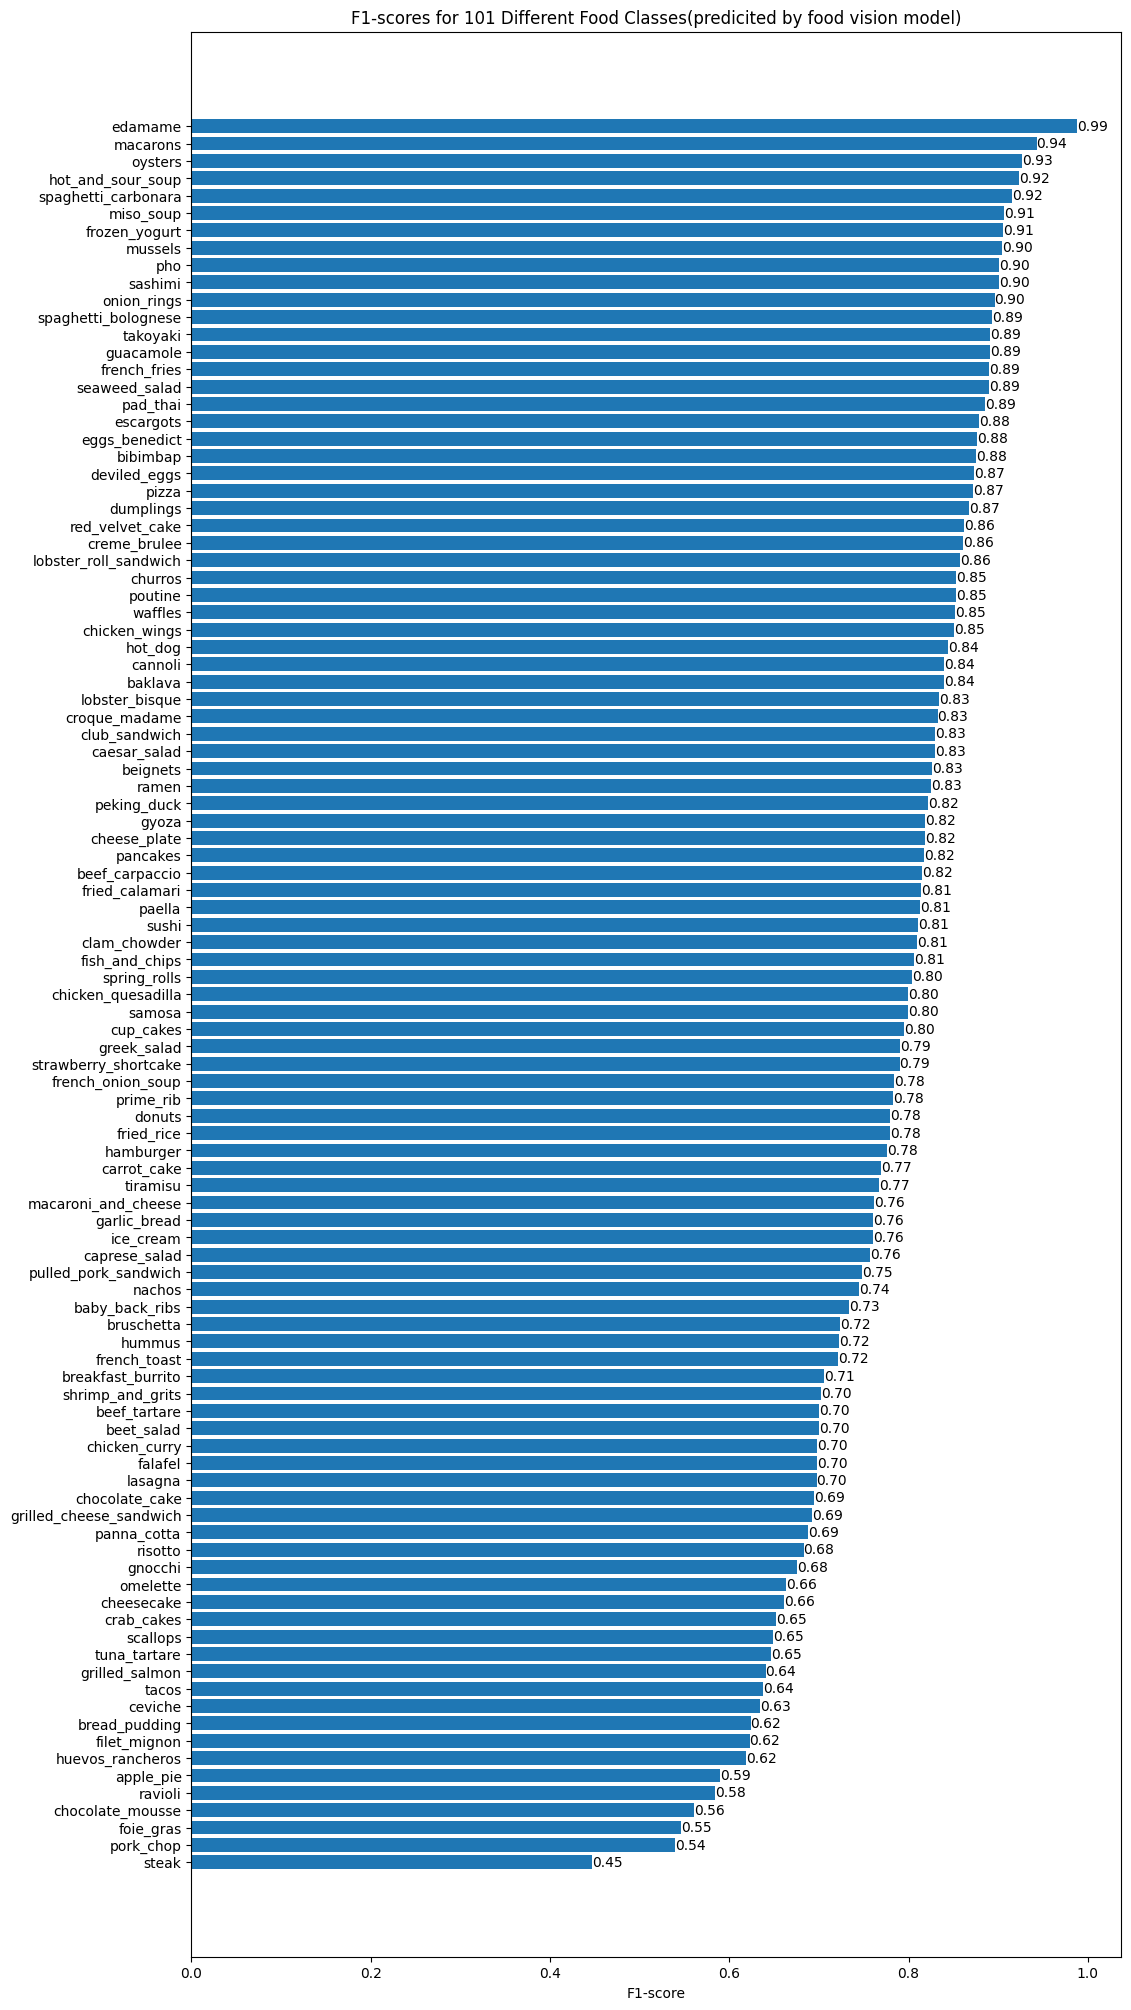

In [134]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))

# PLot the horizontal bars
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)

# Set the y-ticks and labels
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])

# Set the x-label and title
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes(predicited by food vision model)")

# Invert the y-axis
ax.invert_yaxis()

# Add labels to the bars
for i , score in enumerate(f1_scores["f1-score"].values):
    ax.text(score, i, f"{score:.2f}", ha="left", va="center")

plt.show()

## Visualizing prediction on custom images
Now, this is the real test, how does our model go on food images not even in our test dataset(images of our own)

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Resize the image to be in the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1(if necessary)

In [176]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label predictions. Specifically, we'll write some code to:

1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label

In [136]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf

def plot_random_images_with_predictions(model, test_data, class_names, num_rows, num_cols, img_shape=224):
    """
    Plots a batch of random images from the test dataset and displays their true labels, predicted labels,
    and prediction probabilities.

    Parameters:
        model (tf.keras.Model): The trained model for making predictions.
        test_data (tf.data.Dataset): The test dataset containing images and labels.
        class_names (list): List of class names.
        num_rows (int): Number of rows of images in the plot.
        num_cols (int): Number of columns of images in the plot.
        img_shape (int): Desired image shape (required by model).

    Returns:
        None (plots the images and labels using matplotlib).
    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.ravel()
    random_indices = random.sample(range(len(test_data)), num_rows * num_cols)

    for i, rand_index in enumerate(random_indices):
        test_item = test_data.skip(rand_index).take(1)
        for image, label in test_item:
            img = image.numpy()
            true_label = class_names[label]
            img = tf.image.resize(img, [img_shape, img_shape])

            preds_prob = model.predict(tf.expand_dims(img, axis=0))
            pred_label_index = tf.argmax(preds_prob, axis=1).numpy()[0]
            pred_label = class_names[pred_label_index]

            axes[i].imshow(img / 255.)
            if true_label == pred_label:
                title_color = "g"
            else:
                title_color = "r"
            axes[i].set_title(f"True Label: {true_label}, \n Predicted Label: {pred_label},\n Prob: {preds_prob.max():.2f}", color=title_color)
            axes[i].axis('off')

    plt.subplots_adjust(hspace=0.5)
    plt.show();

1/1 [==============================] - 0s 25ms/step


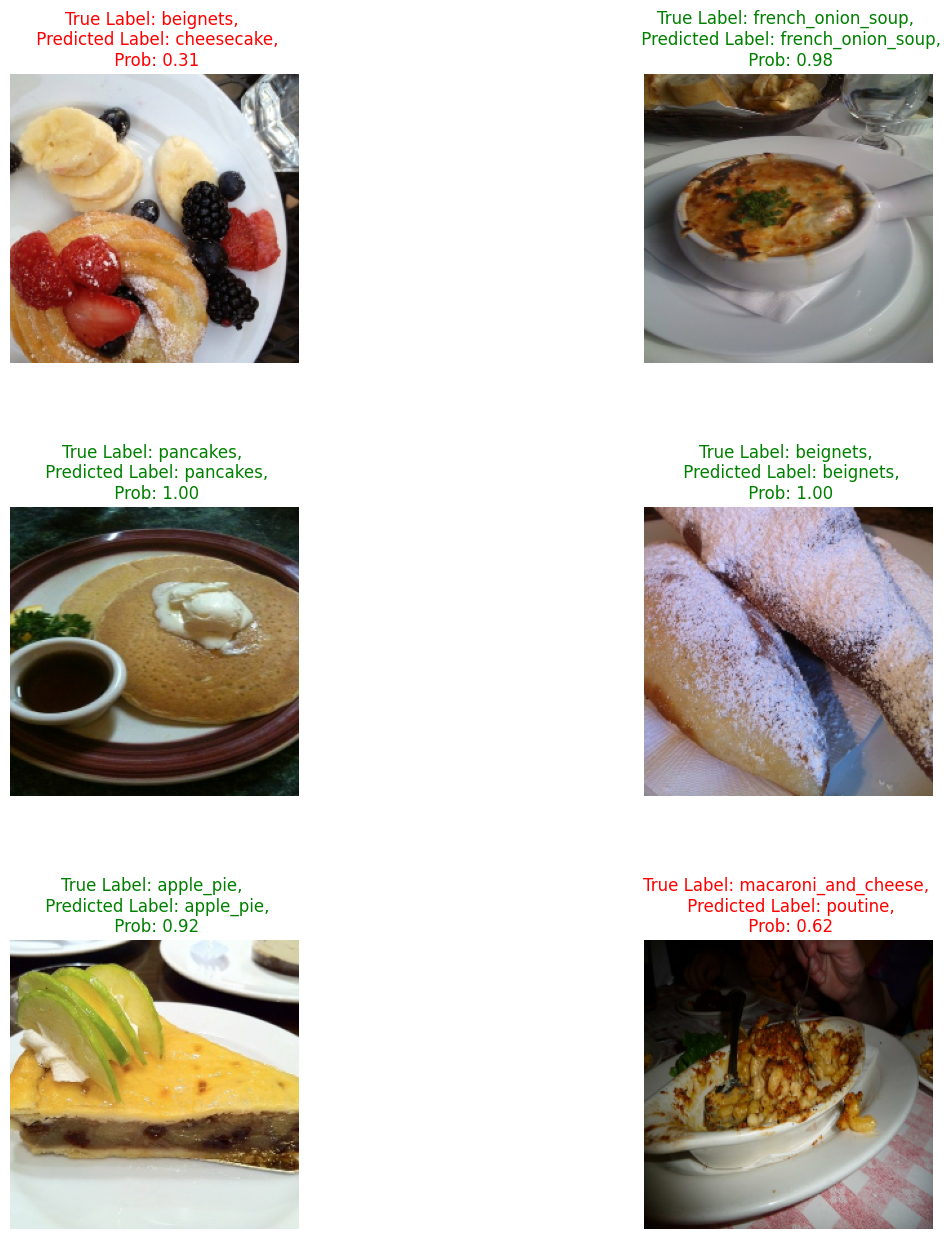

In [139]:
# Usage example:
num_rows = 3
num_cols = 2
plot_random_images_with_predictions(model_fine_tuned, test_data, class_names, num_rows, num_cols);

## Finding the most wrong Predictions

It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These most wrong predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:

1. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.

* **Note:** We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.

2. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
3. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.



In [140]:
len(test_data)

25250

In [141]:
# 1. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_prob.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

y_true  y_pred  pred_conf     y_true_classname     y_pred_classname
0      29      29   0.751328            cup_cakes            cup_cakes
1      81      81   0.976945                ramen                ramen
2      91      91   0.999985  spaghetti_carbonara  spaghetti_carbonara
3      53      53   0.999744            hamburger            hamburger
4      97      97   0.996415             takoyaki             takoyaki

In [142]:
# 2. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

y_true  y_pred  pred_conf     y_true_classname     y_pred_classname  \
0      29      29   0.751328            cup_cakes            cup_cakes   
1      81      81   0.976945                ramen                ramen   
2      91      91   0.999985  spaghetti_carbonara  spaghetti_carbonara   
3      53      53   0.999744            hamburger            hamburger   
4      97      97   0.996415             takoyaki             takoyaki   

   pred_correct  
0          True  
1          True  
2          True  
3          True  
4          True

And now since we know which predictions were right or wrong and along with their prediction probabilities, how about we get the 100 "most wrong" predictions by sorting for wrong predictions and descending prediction probabilties?

In [149]:
# 3. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(10)

y_true  y_pred  pred_conf  y_true_classname y_pred_classname  \
9735       87      30        1.0          scallops     deviled_eggs   
900        14      29        1.0       carrot_cake        cup_cakes   
15437      56      66        1.0  huevos_rancheros           nachos   
22441      16      17        1.0        cheesecake     cheese_plate   
7659       68      70        1.0       onion_rings         pad_thai   
13884      46      10        1.0      garlic_bread       bruschetta   
1812       31      29        1.0            donuts        cup_cakes   
8960       82      34        1.0           ravioli    eggs_benedict   
24513      23      43        1.0           churros   fried_calamari   
22926      86      95        1.0           sashimi            sushi   

       pred_correct  
9735          False  
900           False  
15437         False  
22441         False  
7659          False  
13884         False  
1812          False  
8960          False  
24513         False  
22926         False

Very interesting... just by comparing the ground truth classname (y_true_classname) and the prediction classname column (y_pred_classname), do you notice any trends?

Visualzing will be more useful...

Let's plot 9(to prettify) False positive predictions

1/1 [==============================] - 0s 27ms/step


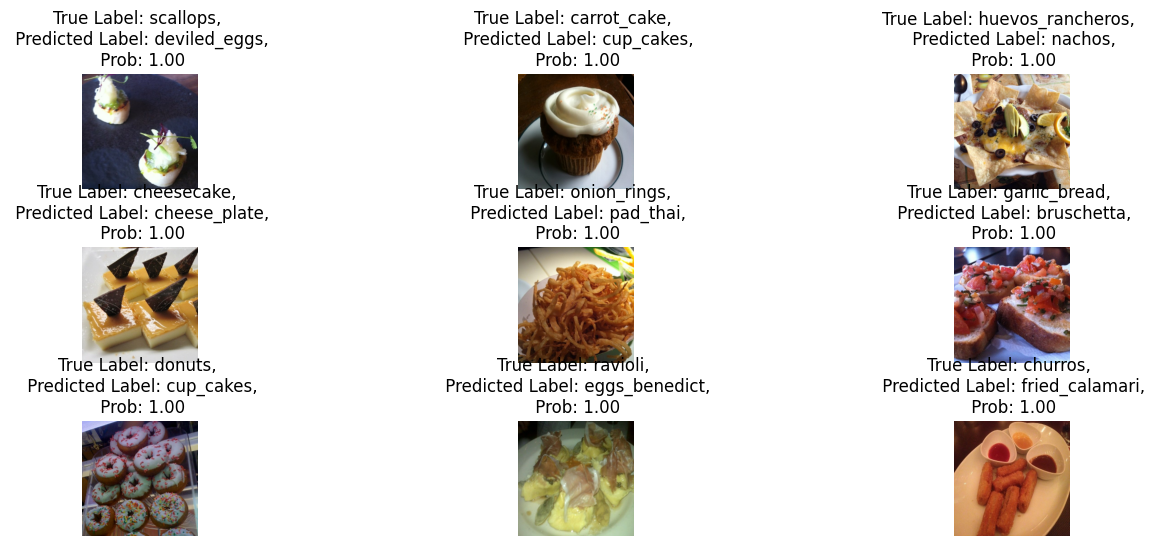

In [158]:
# 4. Visualize the top wrong predictions

# Get the top 9 indices from the DataFrame
top_9_indices = top_100_wrong.head(9).index

# Determine the number of rows and columns based on the number of images
num_images = len(top_9_indices)
num_rows = int(num_images**0.5)  # Square root to get close to a square grid
num_cols = (num_images + num_rows - 1) // num_rows  # Ensure all images fit

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))
axes = axes.ravel()

# Iterate through the top 9 indices and plot in subplots
for i, index in enumerate(top_9_indices):
    # Skip to the desired index in the test dataset
    test_item = test_data.skip(index).take(1)

    for image, label in test_item:
        img = image.numpy()
        true_label = class_names[label]
        img = tf.image.resize(img, [img_shape, img_shape])

        preds_prob = model.predict(tf.expand_dims(img, axis=0))
        pred_label_index = tf.argmax(preds_prob, axis=1).numpy()[0]
        pred_label = class_names[pred_label_index]

        # Plot in the corresponding subplot
        axes[i].imshow(img / 255.)
        axes[i].set_title(f"True Label: {true_label}, \n Predicted Label: {pred_label},\n Prob: {preds_prob.max():.2f}")
        axes[i].axis('off')

# Adjust subplot layout
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

1/1 [==============================] - 0s 32ms/step


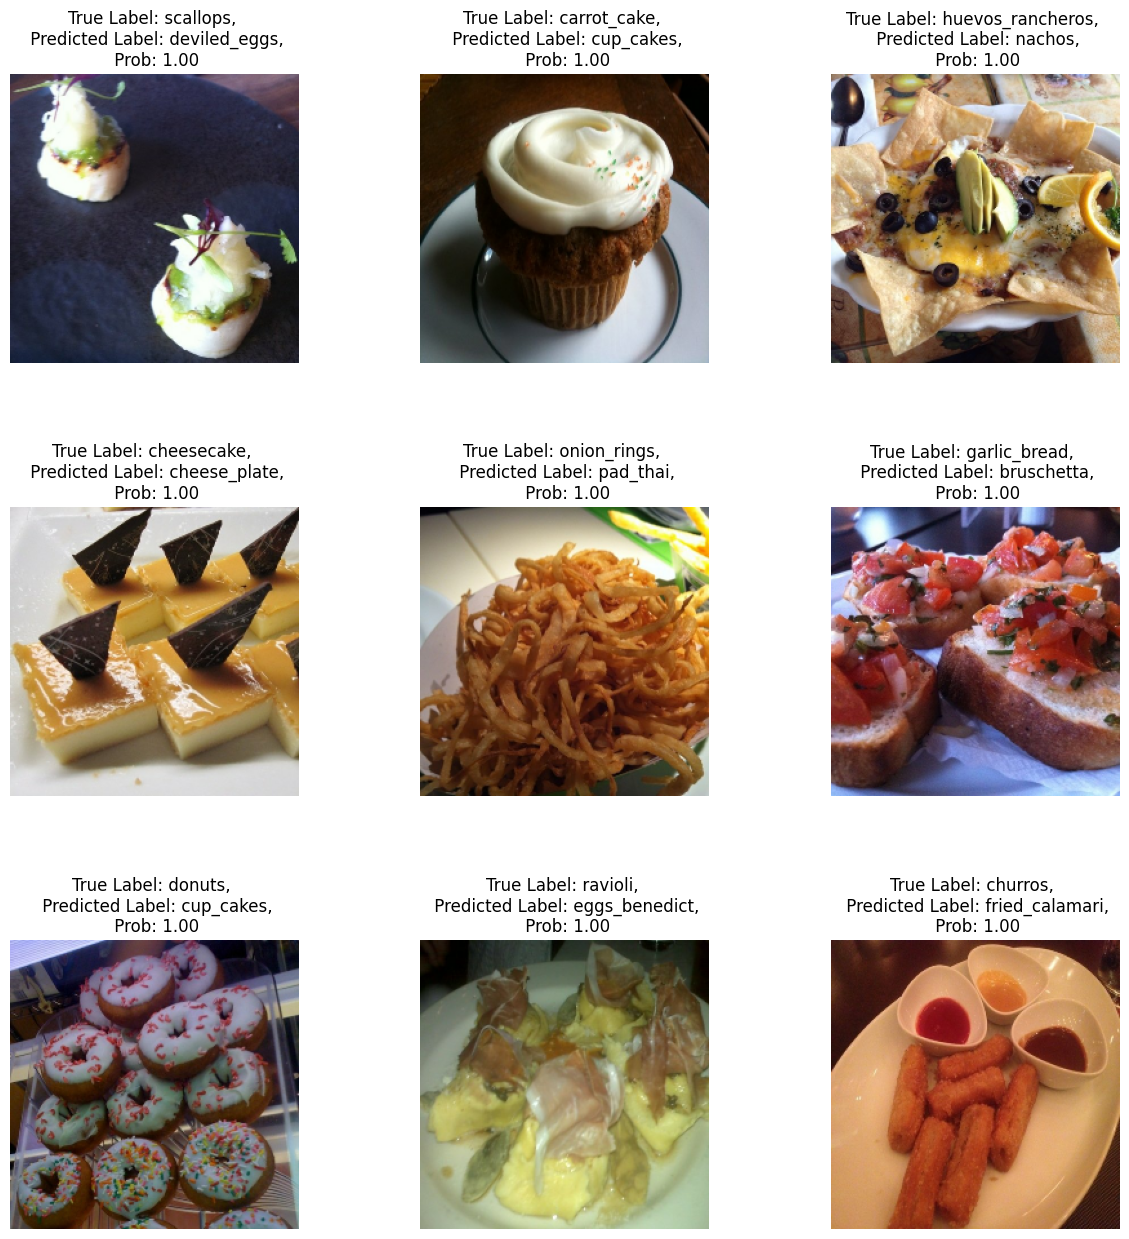

In [161]:
  # 4. Visualize the top wrong predictions

# Get the top 9 indices from the DataFrame
top_9_indices = top_100_wrong.head(9).index

# Determine the number of rows and columns based on the number of images
num_images = len(top_9_indices)
num_rows = int(num_images**0.5)  # Square root to get close to a square grid
num_cols = (num_images + num_rows - 1) // num_rows  # Ensure all images fit


fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.ravel()

# Iterate through the top 9 indices and plot in subplots
for i, index in enumerate(top_9_indices):
    # Skip to the desired index in the test dataset
    test_item = test_data.skip(index).take(1)

    for image, label in test_item:
        img = image.numpy()
        true_label = class_names[label]
        img = tf.image.resize(img, [img_shape, img_shape])

        preds_prob = model.predict(tf.expand_dims(img, axis=0))
        pred_label_index = tf.argmax(preds_prob, axis=1).numpy()[0]
        pred_label = class_names[pred_label_index]

        # Plot in the corresponding subplot
        axes[i].imshow(img / 255.)
        axes[i].set_title(f"True Label: {true_label}, \n Predicted Label: {pred_label},\n Prob: {preds_prob.max():.2f}")
        axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show();

## Test out the model on  custom images of food

In [167]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2023-09-20 12:19:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 64.233.182.207, 64.233.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.05s   

2023-09-20 12:19:04 (266 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



Wonderful, we can load these in and turn them into tensors using our `load_and_prep_image()` function but first we need a list of image filepaths.

In [168]:
import os
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg']

1/1 [==============================] - 0s 32ms/step


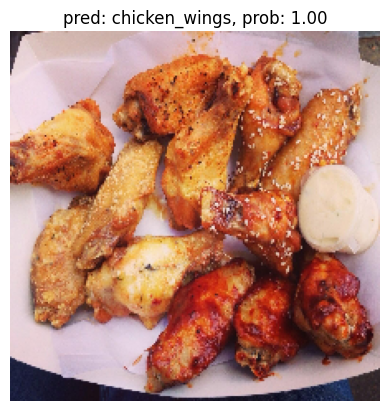

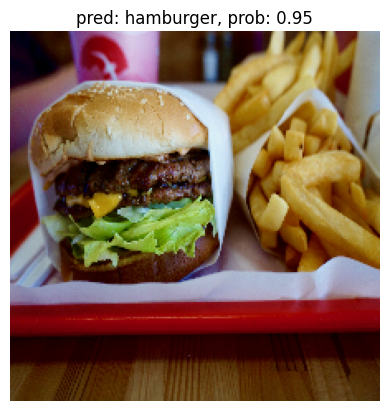

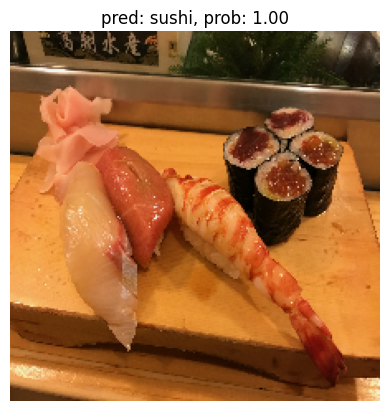

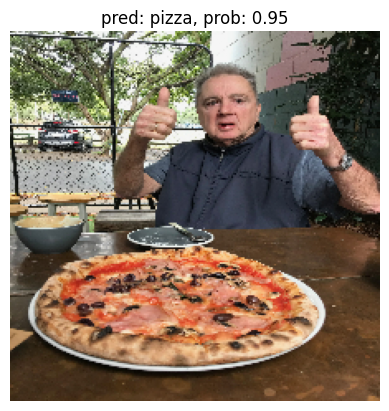

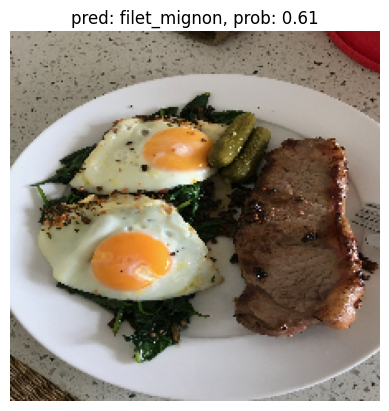

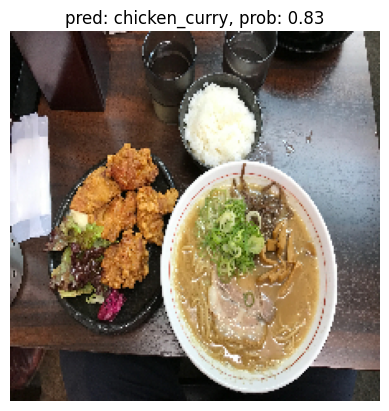

In [177]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, img_shape=224, scale=False) # load in target image and turn it into tensor
  pred_prob = model_fine_tuned.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

Voilaa! Super cool! Seeing a machine learning model work on a premade test dataset is cool but seeing it work on your own data is mind blowing.